<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/optimization/opt_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization (JAX version)

In this notebook, we explore various  algorithms
for solving optimization problems of the form
$$
x* = \arg \min_{x \in X} f(x)
$$
We focus on the case where $f: R^D \rightarrow R$ is a differentiable function

## TOC
* [Automatic differentiation](#AD)
* [Second-order full-batch optimization](#second)
* [Stochastic gradient descent](#SGD)


In [46]:
import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial
import os

import numpy as np
#np.set_printoptions(precision=3)
np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [11]:
# https://github.com/google/jax
import jax
import jax.numpy as jnp

from jax.scipy.special import logsumexp
from jax import grad, hessian, jacfwd, jacrev, jit, vmap
from jax.experimental import optimizers
print("jax version {}".format(jax.__version__))



jax version 0.2.7


# Fit a binary logistic regression model using sklearn

As a running example, we will use binary logistic regression on the iris dataset.

In [8]:
# Fit the model to a dataset, so we have an "interesting" parameter vector to use.

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"]
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)
w_mle_sklearn = jnp.ravel(log_reg.coef_)
print(w_mle_sklearn)

[-4.414 -9.111  6.539 12.686]


# Objectives and their gradients

The key input to an optimization algorithm (aka solver) is the objective function and its gradient. As an example, we use negative log likelihood for a binary logistic regression model as the objective. We compute the gradient by hand, and also use JAX's autodiff feature.


## Manual differentiation <a class="anchor" id="AD"></a>

We compute the gradient of the negative log likelihood for binary logistic regression applied to the Iris dataset. 

In [12]:

# Binary cross entropy
def BCE_with_logits(logits, targets):
  #BCE = -sum_n log(p1)*yn + log(p0)*y0
  #p1 = 1/(1+exp(-a)
  #log(p1) = log(1) - log(1+exp(-a)) = 0 - logsumexp(0, -a)
  N = logits.shape[0]
  logits = logits.reshape(N,1)
  logits_plus = jnp.hstack([jnp.zeros((N,1)), logits]) # e^0=1
  logits_minus = jnp.hstack([jnp.zeros((N,1)), -logits])
  logp1 = -logsumexp(logits_minus, axis=1)
  logp0 = -logsumexp(logits_plus, axis=1)
  logprobs = logp1 * targets + logp0 * (1-targets)
  return -jnp.sum(logprobs)/N

def sigmoid(x): return 0.5 * (jnp.tanh(x / 2.) + 1)

def predict_logit(weights, inputs):
    return jnp.dot(inputs, weights) 

def predict_prob(weights, inputs):
    return sigmoid(predict_logit(weights, inputs))

def NLL(weights, batch):
    X, y = batch
    logits = predict_logit(weights, X)
    return BCE_with_logits(logits, y)

def NLL_grad(weights, batch):
    X, y = batch
    N = X.shape[0]
    mu = predict_prob(weights, X)
    g = jnp.sum(jnp.dot(jnp.diag(mu - y), X), axis=0)/N
    return g


In [15]:
w = w_mle_sklearn
y_pred = predict_prob(w, X_test)
loss = NLL(w, (X_test, y_test))
grad_np = NLL_grad(w, (X_test, y_test))
print("params {}".format(w))
#print("pred {}".format(y_pred))
print("loss {}".format(loss))
print("grad {}".format(grad_np))

params [-4.414 -9.111  6.539 12.686]
loss 0.11824002861976624
grad [-0.235 -0.122 -0.198 -0.064]


## Automatic differentiation in JAX  <a class="anchor" id="AD-jax"></a>

Below we use JAX to compute the gradient of the NLL for binary logistic regression.



In [16]:

grad_jax = grad(NLL)(w, (X_test, y_test))
print("grad {}".format(grad_jax))
assert np.allclose(grad_np, grad_jax)

grad [-0.235 -0.122 -0.198 -0.064]


# Second-order, full-batch optimization <a class="anchor" id="second"></a>

The "gold standard" of optimization is second-order methods, that leverage Hessian information. Since the Hessian has O(D^2) parameters, such methods do not scale to high-dimensional problems. However, we can sometimes approximate the Hessian using low-rank or diagonal approximations. Below we illustrate the low-rank BFGS method, and the limited-memory version of BFGS, that uses O(D H) space and O(D^2) time per step, where H is the history length.

In general, second-order methods also require exact (rather than noisy) gradients. In the context of ML, this means they are "full batch" methods, since computing the exact gradient requires evaluating the loss on all the datapoints. However, for small data problems, this is feasible (and advisable).

Below we illustrate how to use LBFGS as in [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)
                    

In [18]:
import scipy.optimize

def training_loss(w):
    return NLL(w, (X_train, y_train))

def training_grad(w):
    return NLL_grad(w, (X_train, y_train))

np.random.seed(42)
w_init = np.random.randn(D)

options={'disp': None,   'maxfun': 1000, 'maxiter': 1000}
method = 'BFGS'
# The gradient function is specified via the Jacobian keyword
w_mle_scipy = scipy.optimize.minimize(training_loss, w_init, jac=training_grad, method=method, options=options).x   

print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from scipy-bfgs {}".format(w_mle_scipy))
assert np.allclose(w_mle_sklearn, w_mle_scipy, atol=1e-1)

parameters from sklearn [-4.414 -9.111  6.539 12.686]
parameters from scipy-bfgs [-4.415 -9.115  6.541 12.692]


In [20]:
# Limited memory version requires that we work with 64bit, since implemented in Fortran.

def training_loss_64bit(w):
    l = NLL(w, (X_train, y_train))
    return np.float64(l)

def training_grad_64bit(w):
    g = NLL_grad(w, (X_train, y_train))
    return np.asarray(g, dtype=np.float64)

np.random.seed(42)
w_init = np.random.randn(D)                 

memory = 10
options={'disp': None, 'maxcor': memory,  'maxfun': 1000, 'maxiter': 1000}
# The code also handles bound constraints, hence the name
method = 'L-BFGS-B'
#w_mle_scipy = scipy.optimize.minimize(training_loss, w_init, jac=training_grad, method=method).x 
w_mle_scipy = scipy.optimize.minimize(training_loss_64bit, w_init, jac=training_grad_64bit, method=method).x 


print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from scipy-lbfgs {}".format(w_mle_scipy))
assert np.allclose(w_mle_sklearn, w_mle_scipy, atol=1e-1)

parameters from sklearn [-4.414 -9.111  6.539 12.686]
parameters from scipy-lbfgs [-4.415 -9.114  6.54  12.692]


# Stochastic gradient descent <a class="anchor" id="SGD"></a>

In this section we  illustrate how to implement SGD. We apply it to a simple convex problem, namely MLE for binary logistic regression on the small iris dataset, so we can compare to the exact batch methods we illustrated above.
We make use of [Tensorflow datasets](https://github.com/probml/pyprobml/tree/master/book1/intro/tfds_intro.ipynb) to convert our data to a stream of minibatches.

## Numpy version
We show a minimal implementation of SGD using vanilla numpy. For convenience, we use TFDS to create a stream of mini-batches. We compute gradients by hand, but can use any AD library.


In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds

def make_batch_stream(X_train, y_train, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices({"X": X_train, "y": y_train})
  batches = dataset.batch(batch_size)
  batch_stream = tfds.as_numpy(batches)  # finite iterable of dict of NumPy arrays
  N = X_train.shape[0]
  nbatches = int(np.floor(N/batch_size))
  print('{} examples split into {} batches of size {}'.format(N, nbatches, batch_size))
  return batch_stream

batch_stream = make_batch_stream(X_train, y_train, 20)
for epoch in range(2):
  print('epoch {}'.format(epoch))
  for batch in batch_stream:
    x, y = batch["X"], batch["y"]
    print(x.shape) # batch size * num features = 4

100 examples split into 5 batches of size 20
epoch 0
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
epoch 1
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)


In [22]:
def sgd(params, loss_fn, grad_loss_fn, batch_iter, max_epochs, lr):
    print_every = max(1, int(0.1*max_epochs))
    for epoch in range(max_epochs):
        epoch_loss = 0.0
        for batch_dict in batch_iter:
            x, y = batch_dict["X"], batch_dict["y"]
            batch = (x, y)
            batch_grad = grad_loss_fn(params, batch)
            params = params - lr*batch_grad
            batch_loss = loss_fn(params, batch) # Average loss within this batch
            epoch_loss += batch_loss
        if epoch % print_every == 0:
            print('Epoch {}, batch Loss {}'.format(epoch, batch_loss))
    return params,


In [23]:
np.random.seed(42)
w_init = np.random.randn(D) 

max_epochs = 5
lr = 0.1
batch_size = 10
batch_stream = make_batch_stream(X_train, y_train, batch_size)
w_mle_sgd = sgd(w_init, NLL, NLL_grad, batch_stream, max_epochs, lr)
print(w_mle_sgd)

100 examples split into 10 batches of size 10
Epoch 0, batch Loss 0.36490145325660706
Epoch 1, batch Loss 0.34500643610954285
Epoch 2, batch Loss 0.32851698994636536
Epoch 3, batch Loss 0.3143332600593567
Epoch 4, batch Loss 0.3018316626548767
(DeviceArray([-0.538, -0.827,  0.613,  1.661], dtype=float32),)


## Jax version <a class="anchor" id="SGD-jax"></a>

JAX has a small optimization library focused on stochastic first-order optimizers. Every optimizer is modeled as an (`init_fun`, `update_fun`, `get_params`) triple of functions. The `init_fun` is used to initialize the optimizer state, which could include things like momentum variables, and the `update_fun` accepts a gradient and an optimizer state to produce a new optimizer state. The `get_params` function extracts the current iterate (i.e. the current parameters) from the optimizer state. The parameters being optimized can be ndarrays or arbitrarily-nested list/tuple/dict structures, so you can store your parameters however you’d like.

Below we show how to reproduce our numpy code using this library.

In [24]:
# Version that uses JAX optimization library

#@jit
def sgd_jax(params, loss_fn, batch_stream, max_epochs, opt_init, opt_update, get_params):
    loss_history = []
    opt_state = opt_init(params)
    
    #@jit
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        g = grad(loss_fn)(params, batch)
        return opt_update(i, g, opt_state) 
    
    print_every = max(1, int(0.1*max_epochs))
    total_steps = 0
    for epoch in range(max_epochs):
        epoch_loss = 0.0
        for batch_dict in batch_stream:
            X, y = batch_dict["X"], batch_dict["y"]
            batch = (X, y)
            total_steps += 1
            opt_state = update(total_steps, opt_state, batch)
        params = get_params(opt_state)
        train_loss = np.float(loss_fn(params, batch))
        loss_history.append(train_loss)
        if epoch % print_every == 0:
            print('Epoch {}, batch loss {}'.format(epoch, train_loss))
    return params, loss_history

In [25]:
# JAX with constant LR should match our minimal version of SGD

schedule = optimizers.constant(step_size=lr)
opt_init, opt_update, get_params = optimizers.sgd(step_size=schedule)

w_mle_sgd2, history = sgd_jax(w_init, NLL, batch_stream, max_epochs, 
                              opt_init, opt_update, get_params)
print(w_mle_sgd2)
print(history)

Epoch 0, batch loss 0.36490148305892944
Epoch 1, batch loss 0.34500643610954285
Epoch 2, batch loss 0.32851701974868774
Epoch 3, batch loss 0.3143332004547119
Epoch 4, batch loss 0.3018316924571991
[-0.538 -0.827  0.613  1.661]
[0.36490148305892944, 0.34500643610954285, 0.32851701974868774, 0.3143332004547119, 0.3018316924571991]


# Fitting flax models

Below we show how to fit a multi-class logistic regression model using flax. 

## Import code

In [26]:
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

In [27]:
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax import optim

from jax.config import config
config.enable_omnistaging() # Linen requires enabling omnistaging

In [28]:
# Book code
!git clone https://github.com/probml/pyprobml

Cloning into 'pyprobml'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 5489 (delta 29), reused 16 (delta 6), pack-reused 5427
Receiving objects: 100% (5489/5489), 197.46 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (3084/3084), done.
Checking out files: 100% (473/473), done.


In [30]:
!cat pyprobml/scripts/fit_flax.py

# Fitting functions for flax models


import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd


def fit_model(model, train_iter, test_iter,  rng,
        num_steps, make_optimizer, train_batch, eval_batch,
        preprocess_train_batch = None, preprocess_test_batch = None,
        print_every = 1, eval_every = 1):
  batch = next(train_iter)
  X = batch['X']
  params = model.init(rng, X)['params']
  optimizer = make_optimizer.create(params)  
  history = pd.DataFrame({'train_loss': [], 'train_accuracy': [],
                   'test_loss': [], 'test_accuracy': [], 'step': []})
  
  for step in range(num_steps):
    batch = next(train_iter)
    if preprocess_train_batch is not None:
      batch = preprocess_train_batch(batch, rng)
    optimizer, train_metrics = train_batch(model, optimizer, batch)
    if (print_every > 0) & (step % print_every == 0):
       print('train step: {:d}, loss: {:0.4f}, accuracy: {:0.2f}'.format(
              step, train_metrics['loss'], 
   

In [31]:
os.chdir('pyprobml/scripts')
import fit_flax as ff
ff.fit_model_test()

train step: 0, loss: 3.4245, accuracy: 0.00
train step: 1, loss: 3.2471, accuracy: 0.00
test passed


In [ ]:

from google.colab import files
#files.view('fit_flax.py')

## Data

In [38]:
import tensorflow as tf
import tensorflow_datasets as tfds

import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split

def get_datasets_iris():
  iris = sklearn.datasets.load_iris()
  X = iris["data"]
  y = iris["target"] 
  N, D = X.shape # 150, 4
  X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.33, random_state=42)
  train_data = {'X': X_train, 'y': y_train}
  test_data = {'X': X_test, 'y': y_test}
  return train_data, test_data

def load_dataset_iris(split, batch_size=None):
  train_ds, test_ds = get_datasets_iris()
  if split == tfds.Split.TRAIN:
    ds = tf.data.Dataset.from_tensor_slices({"X": train_ds["X"], "y": train_ds["y"]})
  elif split == tfds.Split.TEST:
    ds = tf.data.Dataset.from_tensor_slices({"X": test_ds["X"], "y": test_ds["y"]})
  if batch_size is not None:
    ds = ds.shuffle(buffer_size=batch_size)
    ds = ds.batch(batch_size)
  else:
    N = len(train_ds['X'])
    ds = ds.batch(N)
  ds = ds.prefetch(buffer_size=5)
  ds = ds.repeat() # make infinite stream of data
  return iter(tfds.as_numpy(ds)) # python iterator


batch_size = 30
train_ds = load_dataset_iris(tfds.Split.TRAIN, batch_size)
batch = next(train_ds)
print(batch['X'].shape)
print(batch['y'].shape)

test_ds = load_dataset_iris(tfds.Split.TEST, None) # load full test set
batch = next(test_ds)
print(batch['X'].shape)
print(batch['y'].shape)

(30, 4)
(30,)
(50, 4)
(50,)


## Model

In [34]:
class Model(nn.Module):
  nhidden: int
  nclasses: int

  @nn.compact
  def __call__(self, x):
    if self.nhidden > 0:
      x = nn.Dense(self.nhidden)(x)
      x = nn.relu(x)
    x = nn.Dense(self.nclasses)(x)
    x = nn.log_softmax(x)
    return x

## Training loop


In [41]:
from flax import optim

make_optimizer = optim.Momentum(learning_rate=0.1, beta=0.9)

model = Model(nhidden = 0, nclasses=3) # no hidden units ie logistic regression

batch_size = 100 # 30 # full batch training
train_ds = load_dataset_iris(tfds.Split.TRAIN, batch_size)
test_ds = load_dataset_iris(tfds.Split.TEST, batch_size)


def preprocess_batch(batch, prng_key = None):
  X = batch['X']
  y = batch['y']
  #d = {'X': X, 'y': onehot(y, num_classes=3)}
  d = {'X': X, 'y': y}
  return d

rng = jax.random.PRNGKey(0)
num_steps = 200

params, history =  ff.fit_model(model, train_ds, test_ds,  rng,
        num_steps, make_optimizer,
        ff.train_batch, ff.eval_batch, 
        print_every=50, eval_every=50)
  
display(history)

train step: 0, loss: 4.2830, accuracy: 0.35
train step: 50, loss: 0.1424, accuracy: 0.94
train step: 100, loss: 0.1041, accuracy: 0.98
train step: 150, loss: 0.0955, accuracy: 0.98


,train_loss,train_accuracy,test_loss,test_accuracy,step
0,4.2829556,0.35,1.8996173,0.28,0.0
1,0.14242826,0.94,0.13580628,0.9,50.0
2,0.10408674,0.97999996,0.086586,1.0,100.0
3,0.09550042,0.97999996,0.08249063,0.97999996,150.0


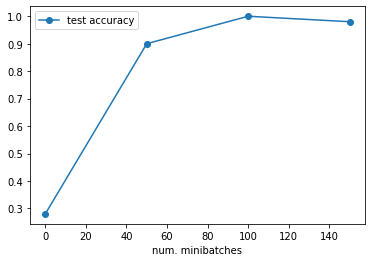

In [42]:
plt.figure()
plt.plot(history['step'], history['test_accuracy'], 'o-', label='test accuracy')
plt.xlabel('num. minibatches')
plt.legend()
plt.show()

## Compare to sklearn


In [47]:
train_ds, test_ds = get_datasets_iris()
from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
log_reg = LogisticRegression(solver="lbfgs", C=1e3, fit_intercept=True)
log_reg.fit(train_ds['X'], train_ds['y'])

w_sklearn = np.ravel(log_reg.coef_)
print(w_sklearn)
b_sklearn = np.ravel(log_reg.intercept_)
print(b_sklearn)

yprob_sklearn = log_reg.predict_proba(test_ds['X'])
print(yprob_sklearn.shape)
print(yprob_sklearn[:10,:])


ypred_sklearn = jnp.argmax(yprob_sklearn, axis=-1)
print(ypred_sklearn.shape)
print(ypred_sklearn[:10])

[5.69473 8.89993 -12.90385 -6.59589 -1.40077 1.88896 0.08464 -14.39687
 -4.29397 -10.78889 12.81921 20.99277]
[3.97582 32.52712 -36.50294]
(50, 3)
[[0.00000 1.00000 0.00000]
 [1.00000 0.00000 0.00000]
 [0.00000 0.00000 1.00000]
 [0.00000 0.99999 0.00000]
 [0.00001 0.99999 0.00000]
 [1.00000 0.00000 0.00000]
 [0.00605 0.99395 0.00000]
 [0.00000 0.00000 1.00000]
 [0.00000 0.98867 0.01133]
 [0.00006 0.99994 0.00000]]
(50,)
[1 0 2 1 1 0 1 2 1 1]


In [48]:
# Flax version
print(params)

train_ds, test_ds = get_datasets_iris()
Xtest = test_ds['X']
logits = model.apply({'params': params}, Xtest)
yprob = nn.softmax(logits)
print(yprob.shape)
print(yprob[:10,:])
print(np.allclose(yprob_sklearn, yprob, atol=1e-0)) # very loose numerical tolerance

ypred = jnp.argmax(yprob, axis=-1)
print(ypred[:10])
print(np.allclose(ypred_sklearn, ypred))

FrozenDict({
    Dense_0: {
        bias: DeviceArray([0.67322, 1.05858, -1.73180], dtype=float32),
        kernel: DeviceArray([[1.13125, 0.95521, -2.30099],
                     [2.86528, -0.09720, -3.41202],
                     [-3.86220, -0.45856, 4.46158],
                     [-1.57317, -1.24467, 3.70615]], dtype=float32),
    },
})
(50, 3)
[[0.00057 0.94575 0.05368]
 [0.99750 0.00250 0.00000]
 [0.00000 0.00014 0.99986]
 [0.00131 0.91360 0.08509]
 [0.00045 0.97463 0.02493]
 [0.99551 0.00449 0.00000]
 [0.02960 0.96893 0.00147]
 [0.00008 0.27976 0.72016]
 [0.00012 0.66911 0.33077]
 [0.00644 0.98950 0.00406]]
True
[1 0 2 1 1 0 1 2 1 1]
True
